In [1]:
# What is different in this kernel:
# - data preprocessing was modularised and hopefully made more clear, as repetitative actions were moved into a separate function
# - LightGBM hyperparameters  were taken from my another kernel, where they were tuned to the `application` data subset only:
#   https://www.kaggle.com/mlisovyi/lightgbm-hyperparameter-optimisation-lb-0-746
#
# What was borrowed in this kernel:
# This script is a fork of the awesome kernel by olivier, that insiper a lot of kernels on this competition:
# https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm
# It also uses memory-footprint-reduction technique copied over from this very clear and useful kernel:
# https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# The tiny add-on to store OOF predictions on the training dataset was taken from this kernel:
# https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/


import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import gc


In [44]:

PATH='./'

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df
    
def average_dummies(df, dummy_col, count_col, gb_col, preffix='', del_input=True):
    print('DF shape : ', df.shape)

    if dummy_col:
        print('transform to dummies')
        df = pd.concat([df, pd.get_dummies(df[dummy_col])], axis=1).drop(dummy_col, axis=1)
    
    if count_col and gb_col:
        print('Counting buros')
        df_counts = df[[gb_col, count_col]].groupby(gb_col).count()
        df[count_col] = df[gb_col].map(df_counts[count_col])
    
    avg_df = None
    if gb_col:
        print('averaging ')
        avg_df = df.groupby(gb_col).mean()
        
    if preffix:
        avg_df.columns = [preffix + f_ for f_ in avg_df.columns]
        print(avg_df.head())
        
    print(df.head())
    
    if del_input:
        print('Deleting input')
        del df
        gc.collect()
    
    if avg_df is not None:
        print(avg_df.head())
        print(avg_df.columns.values)
        return avg_df
    elif not del_input:
        return df
    else:
        return None

def feat_ext_source(df):
    x1 = df['EXT_SOURCE_1'].fillna(-1) + 1e-1
    x2 = df['EXT_SOURCE_2'].fillna(-1) + 1e-1
    x3 = df['EXT_SOURCE_3'].fillna(-1) + 1e-1
    
    df['EXT_SOURCE_1over2_NAminus1_Add0.1'] = x1/x2
    df['EXT_SOURCE_2over1_NAminus1_Add0.1'] = x2/x1
    df['EXT_SOURCE_1over3_NAminus1_Add0.1'] = x1/x3
    df['EXT_SOURCE_3over1_NAminus1_Add0.1'] = x3/x1
    df['EXT_SOURCE_2over3_NAminus1_Add0.1'] = x2/x3
    df['EXT_SOURCE_3over2_NAminus1_Add0.1'] = x3/x2
    
    df['EXT_SOURCE_na1_2'] = (df['EXT_SOURCE_1'].isnull()) * (df['EXT_SOURCE_2'].fillna(0))
    df['EXT_SOURCE_na1_3'] = (df['EXT_SOURCE_1'].isnull()) * (df['EXT_SOURCE_3'].fillna(0))
    df['EXT_SOURCE_na2_1'] = (df['EXT_SOURCE_2'].isnull()) * (df['EXT_SOURCE_1'].fillna(0))
    df['EXT_SOURCE_na2_3'] = (df['EXT_SOURCE_2'].isnull()) * (df['EXT_SOURCE_3'].fillna(0))
    df['EXT_SOURCE_na3_1'] = (df['EXT_SOURCE_3'].isnull()) * (df['EXT_SOURCE_1'].fillna(0))
    df['EXT_SOURCE_na3_2'] = (df['EXT_SOURCE_3'].isnull()) * (df['EXT_SOURCE_2'].fillna(0))
    
    return df
    
def build_model_input():
    print('Read Bureau_Balance')
    buro_bal = import_data(PATH+'/bureau_balance.csv')
    avg_buro_bal = average_dummies(buro_bal, dummy_col='STATUS', count_col='MONTHS_BALANCE', gb_col='SK_ID_BUREAU', preffix='avg_buro_')

    print('Read Bureau')
    buro_full = import_data(PATH+'/bureau.csv')
    buro_full = average_dummies(buro_full, dummy_col=['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE'], count_col=None, gb_col=None, preffix=None, del_input=False)
    print('Merge with buro avg')
    buro_full = buro_full.merge(right=avg_buro_bal.reset_index(), how='left', on='SK_ID_BUREAU', suffixes=('', '_bur_bal'))
    avg_buro = average_dummies(buro_full, dummy_col=None, count_col='SK_ID_BUREAU', gb_col='SK_ID_CURR', preffix='avg_buro_', del_input=True)

    print('Read prev')
    prev = import_data(PATH+'/previous_application.csv')
    prev_cat_features = [ f_ for f_ in prev.columns if prev[f_].dtype == 'object'  or prev[f_].dtype.name == 'category'  ]
    avg_prev = average_dummies(prev, dummy_col=prev_cat_features, count_col='SK_ID_PREV', gb_col='SK_ID_CURR', preffix='prev_')

    print('Reading POS_CASH')
    pos = import_data(PATH+'/POS_CASH_balance.csv')
    avg_pos = average_dummies(pos, dummy_col='NAME_CONTRACT_STATUS', count_col='SK_ID_PREV', gb_col='SK_ID_CURR', preffix='pos_')

    print('Reading CC balance')
    cc_bal = import_data(PATH+'/credit_card_balance.csv')
    avg_cc_bal = average_dummies(cc_bal, dummy_col='NAME_CONTRACT_STATUS', count_col='SK_ID_PREV', gb_col='SK_ID_CURR', preffix='cc_bal_')

    print('Reading Installments')
    inst = import_data(PATH+'/installments_payments.csv')
    avg_inst = average_dummies(inst, dummy_col=None, count_col='SK_ID_PREV', gb_col='SK_ID_CURR', preffix='inst_')

    print('Read data and test')
    data = import_data(PATH+'/application_train.csv')
    data = data[data['AMT_INCOME_TOTAL'] != 1.170000e+08]
    data = data[data['AMT_REQ_CREDIT_BUREAU_QRT'] != 261]
    data = data[data['OBS_30_CNT_SOCIAL_CIRCLE'] < 300]
    data['DAYS_EMPLOYED'] = (data['DAYS_EMPLOYED'].apply(lambda x: x if x != 365243 else np.nan))
    data=data.reset_index(drop=True)
    data = feat_ext_source(data)
    test = import_data(PATH+'/application_test.csv')
    test  = feat_ext_source(test)
    
    print('Shapes : ', data.shape, test.shape)
    
    y = data['TARGET']
    del data['TARGET']
    
    categorical_feats = [ f for f in data.columns if data[f].dtype == 'object'  or data[f].dtype.name == 'category' ]
    print('---------------------')
    print(categorical_feats)
    for f_ in categorical_feats:
        data[f_], indexer = pd.factorize(data[f_])
        test[f_] = indexer.get_indexer(test[f_])
    
    print('Merging')
    data = data.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
    
    data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
    test = test.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
    
    del avg_buro, avg_prev
    gc.collect()

    print('Done with data preparation')
    return data, test, y


def train_model(data_, test_, y_, folds_):

    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    
    feature_importance_df = pd.DataFrame()
    
    feats = [f for f in data_.columns if f not in ['SK_ID_CURR']]
    
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_,y_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        
        #clf = LGBMClassifier(
        #    n_estimators=4000,
        #    learning_rate=0.03,
        #    num_leaves=30,
        #    colsample_bytree=.8,
        #    subsample=.9,
        #    max_depth=7,
        #    reg_alpha=.1,
        #    reg_lambda=.1,
        #    min_split_gain=.01,
        #    min_child_weight=2,
        #    silent=-1,
        #    verbose=-1,
        #)
        
        clf = LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000, learning_rate=0.03)
        opt_parameters = {'colsample_bytree': 0.9234, 'min_child_samples': 399, 'min_child_weight': 0.1, 'num_leaves': 13, 'reg_alpha': 2, 'reg_lambda': 5, 'subsample': 0.855}
        clf.set_params(**opt_parameters)
        #clf.set_params(is_unbalance=True)
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=500, early_stopping_rounds=100  #30
               )
        
        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        print('Fold {} most important features are: '.format(n_fold + 1))
        for i in np.argsort(fold_importance_df["importance"])[-5:]:
            print('{}  -> {}'.format(fold_importance_df.iloc[i, 0], fold_importance_df.iloc[i, 1]))
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['TARGET'] = sub_preds
    
    #print(str(len(data_['SK_ID_CURR']))+" "+str(len(y))+" "+str(len(oof_preds)))
    df_oof_preds = pd.DataFrame({'SK_ID_CURR':data_['SK_ID_CURR'], 'TARGET':y, 'PREDICTION':oof_preds})
    #df_oof_preds = df_oof_preds[['SK_ID_CURR', 'TARGET', 'PREDICTION']]

    return oof_preds, df_oof_preds, test_[['SK_ID_CURR', 'TARGET']], feature_importance_df, roc_auc_score(y, oof_preds)
    

def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')


def display_roc_curve(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    scores = [] 
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = roc_auc_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
    fpr, tpr, thresholds = roc_curve(y_, oof_preds_)
    score = roc_auc_score(y_, oof_preds_)
    plt.plot(fpr, tpr, color='b',
             label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LightGBM ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    
    plt.savefig('roc_curve.png')




In [ ]:
gc.enable()
# Build model inputs
data, test, y = build_model_input()

In [51]:
# Create Folds
#folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=31416)#546789)
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=546789)

Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.799729	valid_1's auc: 0.776929
[1000]	training's auc: 0.821335	valid_1's auc: 0.780773
[1500]	training's auc: 0.838631	valid_1's auc: 0.781933
Early stopping, best iteration is:
[1593]	training's auc: 0.841464	valid_1's auc: 0.782051
Fold 1 most important features are: 
AMT_CREDIT  -> 394
DAYS_BIRTH  -> 431
EXT_SOURCE_1  -> 464
EXT_SOURCE_2  -> 533
EXT_SOURCE_3  -> 556
Fold  1 AUC : 0.782051
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.7983	valid_1's auc: 0.783204
[1000]	training's auc: 0.820271	valid_1's auc: 0.786461
Early stopping, best iteration is:
[1345]	training's auc: 0.832328	valid_1's auc: 0.787216
Fold 2 most important features are: 
AMT_ANNUITY  -> 324
DAYS_BIRTH  -> 365
EXT_SOURCE_1  -> 407
EXT_SOURCE_2  -> 488
EXT_SOURCE_3  -> 543
Fold  2 AUC : 0.787216
Training until validation scores don't improve for 100 rounds.
[500]	training's auc: 0.800078

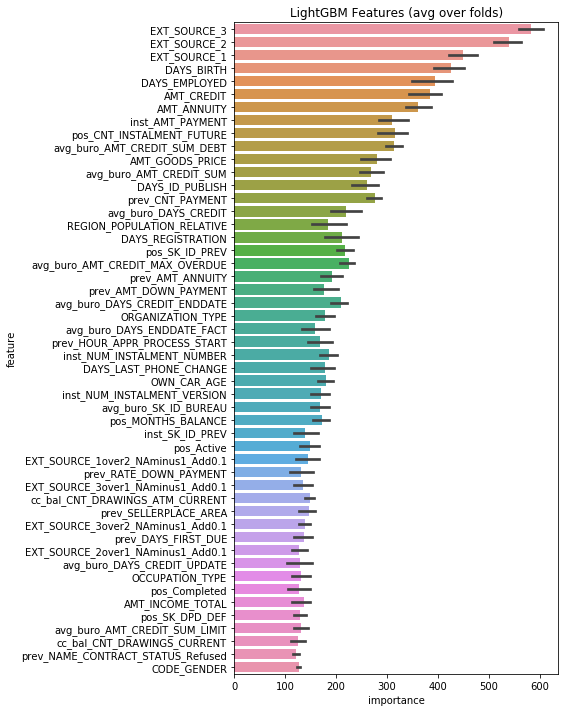

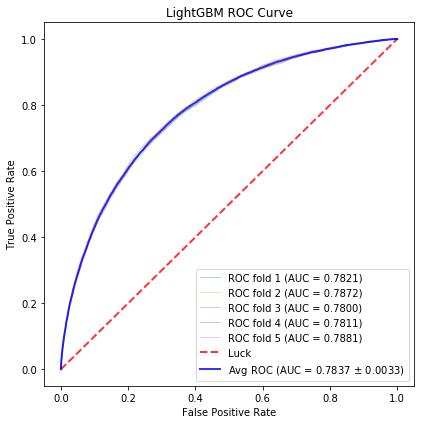

In [52]:
# Train model and get oof and test predictions
oof_preds, df_oof_preds, test_preds, importances, score = train_model(data, test, y, folds)
# Save test predictions
from datetime import datetime
now = datetime.now()
score = str(round(score, 6)).replace('.', '')
sub_file = 'submission_5x-average-LGB-run-v01_' + score + '_' + str(now.strftime('%Y-%m-%d-%H-%M')) + '.csv'
test_preds.to_csv(sub_file, index=False)
#Save OOF predictions
oof_file = 'train_5x-LGB-run-v01-oof_' + score + '_' + str(now.strftime('%Y-%m-%d-%H-%M')) + '.csv'
df_oof_preds.to_csv(oof_file, index=False)
# Display a few graphs
folds_idx = [(trn_idx, val_idx) for trn_idx, val_idx in folds.split(data,y)]
display_importances(feature_importance_df_=importances)
display_roc_curve(y_=y, oof_preds_=oof_preds, folds_idx_=folds_idx)
#display_precision_recall(y_=y, oof_preds_=oof_preds, folds_idx_=folds_idx)


In [24]:
len(data)

306487

In [ ]:
len(data['SK_ID_CURR'])

In [33]:
data_=data.copy()
test_=test.copy()
y_=y.copy()
folds_=folds

oof_preds = np.zeros(data_.shape[0])
sub_preds = np.zeros(test_.shape[0])

feature_importance_df = pd.DataFrame()

feats = [f for f in data_.columns if f not in ['SK_ID_CURR']]

for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_,y_)):
    trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
    val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
    
    #clf = LGBMClassifier(
    #    n_estimators=4000,
    #    learning_rate=0.03,
    #    num_leaves=30,
    #    colsample_bytree=.8,
    #    subsample=.9,
    #    max_depth=7,
    #    reg_alpha=.1,
    #    reg_lambda=.1,
    #    min_split_gain=.01,
    #    min_child_weight=2,
    #    silent=-1,
    #    verbose=-1,
    #)
    
    #clf = LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000, learning_rate=0.03)
    clf = LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5, learning_rate=0.03)
    opt_parameters = {'colsample_bytree': 0.9234, 'min_child_samples': 399, 'min_child_weight': 0.1, 'num_leaves': 13, 'reg_alpha': 2, 'reg_lambda': 5, 'subsample': 0.855}
    clf.set_params(**opt_parameters)
    #clf.set_params(is_unbalance=True)
    
    clf.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric='auc', verbose=500, early_stopping_rounds=100  #30
           )
    
    oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    print('Fold {} most important features are: '.format(n_fold + 1))
    for i in np.argsort(fold_importance_df["importance"])[-5:]:
        print('{}  -> {}'.format(fold_importance_df.iloc[i, 0], fold_importance_df.iloc[i, 1]))
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
    del clf, trn_x, trn_y, val_x, val_y
    gc.collect()
    
print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

test_['TARGET'] = sub_preds

print(str(len(data_['SK_ID_CURR']))+" "+str(len(y))+" "+str(len(oof_preds)))
df_oof_preds = pd.DataFrame({'SK_ID_CURR':data_['SK_ID_CURR'], 'TARGET':y, 'PREDICTION':oof_preds})
#df_oof_preds = df_oof_preds[['SK_ID_CURR', 'TARGET', 'PREDICTION']]

return oof_preds, df_oof_preds, test_[['SK_ID_CURR', 'TARGET']], feature_importance_df, roc_auc_score(y, oof_preds)

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[5]	training's auc: 0.713236	valid_1's auc: 0.705859
Fold 1 most important features are: 
EXT_SOURCE_3over2_NAminus1_Add0.1  -> 3
EXT_SOURCE_1over2_NAminus1_Add0.1  -> 4
DAYS_EMPLOYED  -> 5
EXT_SOURCE_3  -> 18
EXT_SOURCE_2  -> 21
Fold  1 AUC : 0.705859
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[5]	training's auc: 0.712868	valid_1's auc: 0.716748
Fold 2 most important features are: 
cc_bal_CNT_DRAWINGS_ATM_CURRENT  -> 3
EXT_SOURCE_1over2_NAminus1_Add0.1  -> 4
EXT_SOURCE_3over2_NAminus1_Add0.1  -> 4
EXT_SOURCE_3  -> 16
EXT_SOURCE_2  -> 21
Fold  2 AUC : 0.716748
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[5]	training's auc: 0.71154	valid_1's auc: 0.707852
Fold 3 most important features are: 
EXT_SOURCE_3over2_NAminus1_Add0.1  -> 3
EXT_SOURCE_1ov

ValueError: array length 306487 does not match index length 307510

In [38]:
pd.DataFrame({'SK_ID_CURR':data_['SK_ID_CURR'], 'TARGET':y})#, 'PREDICTION':oof_preds})

,SK_ID_CURR,TARGET
0,100002.0,1.0
1,100003.0,0.0
2,100004.0,0.0
3,100006.0,0.0
4,100007.0,0.0
5,100008.0,0.0
6,100009.0,0.0
7,100010.0,0.0
8,100011.0,0.0
9,100012.0,0.0


In [39]:
len(y)

306487